# Data Analysis


More details: https://ctapipe.readthedocs.io/en/latest/api/ctapipe.containers.DL1CameraContainer.html

In [1]:
# import
from ctapipe.io import EventSource

import numpy as np
import matplotlib.pyplot as plt

import glob
import os
import pandas as pd
import random
from collections import deque

from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
import h5py


In [2]:
# path
proton_path = "/home/user/TM/sst1m-ml-triggering/data_processing/calculus_data/data/work/analysis/MC/simtel_sample_NSBmed4_vaod0.05/protons_diffuse/zenith_20deg/"
gammas_path = "/home/user/TM/sst1m-ml-triggering/data_processing/calculus_data/data/work/analysis/MC/simtel_sample_NSBmed4_vaod0.05/gammas_diffuse/zenith_20deg/"

In [3]:

def load_data(folder_path, max_events=None, with_hillas=False, with_leakage=False):
    telescopes = ["tel_001", "tel_002"]
    images_list = []
    masks_list = []
    peaks_list = []
    true_energy_list = []
    leakage_list = []

    file_list = glob.glob(os.path.join(folder_path, "*.h5"))
    random.seed(42)
    random.shuffle(file_list)
    print(f"Found {len(file_list)} files", flush=True)

    for file_idx, file_path in enumerate(file_list, 1):
        with h5py.File(file_path, "r") as f:
            
            ds_energy = f["simulation/event/subarray/shower"][:]
            energy_by_event = {
                row["event_id"]: row["true_energy"]
                for row in ds_energy
            }

            for tel in telescopes:
                ds_image = f[f"dl1/event/telescope/images/{tel}"][:]
                ds_params = f[f"dl1/event/telescope/parameters/{tel}"][:]

                n_events = ds_image.shape[0]

                for i in range(n_events):

                    if with_hillas:
                        if np.isnan(ds_params[i]["hillas_intensity"]):
                            continue
                    else :
                        if np.isnan(ds_params[i]["hillas_intensity"]) == False:
                            continue
                    if with_leakage:
                        if ds_params[i]["leakage_pixels_width_1"] < 0.2:
                            continue

                    event_id = ds_params[i]["event_id"]
                    true_energy = energy_by_event[event_id]

                    images_list.append(ds_image[i]["image"].astype(np.float32))
                    peaks_list.append(ds_image[i]["peak_time"].astype(np.float32))
                    masks_list.append(ds_image[i]["image_mask"].astype(bool))
                    leakage_list.append(ds_params[i]["leakage_pixels_width_1"].astype(np.float32))
                    true_energy_list.append(true_energy.astype(np.float32))

                    if max_events is not None and len(images_list) >= max_events:
                        return images_list, masks_list, peaks_list, true_energy_list, leakage_list

    return images_list, masks_list, peaks_list, true_energy_list, leakage_list

In [4]:
proton_images_hillas, protons_mask, protons_peak, _, _ = load_data(proton_path, with_hillas=True)
gamma_images_hillas, gammas_mask, gammas_peak, _, _= load_data(gammas_path, with_hillas=True)
proton_images_no_hillas, protons_mask_nh, protons_peak_nh, _, _ = load_data(proton_path, with_hillas=False)
gamma_images_no_hillas, gammas_mask_nh, gammas_peak_nh, _, _= load_data(gammas_path, with_hillas=False)
proton_images_leakage, protons_mask, protons_peak, _, proton_leakage = load_data(proton_path, with_leakage=True, with_hillas=True)
gamma_images_leakage, gammas_mask, gammas_peak, _, gamma_leakage = load_data(gammas_path, with_leakage=True, with_hillas=True)

Found 97 files
Found 106 files
Found 97 files
Found 106 files
Found 97 files
Found 106 files


In [5]:
print(f"Proton images with hillas: {len(proton_images_hillas)}")
print(f"Gamma images with hillas: {len(gamma_images_hillas)}")

Proton images with hillas: 64657
Gamma images with hillas: 32627


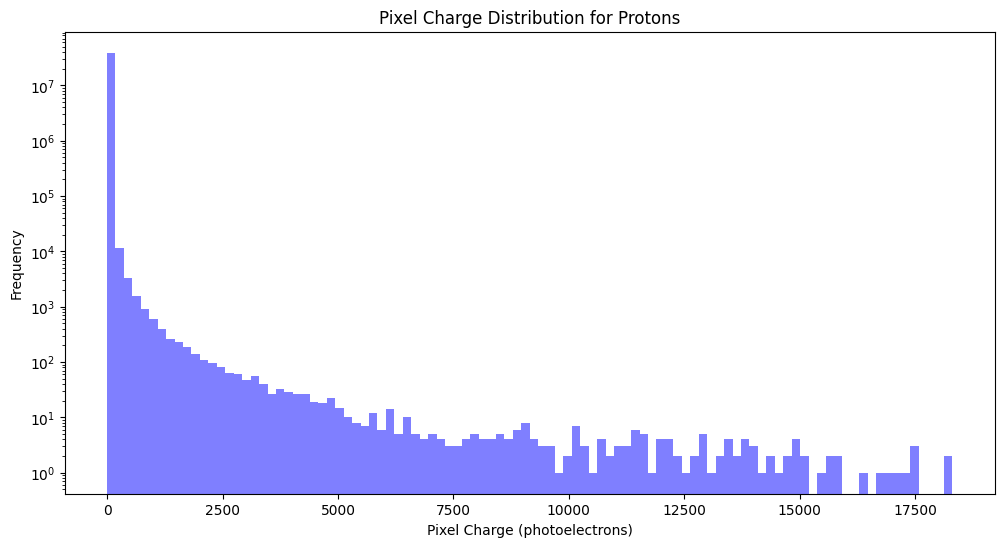

In [ ]:
# Show pixel distribution
proton_images = np.array(proton_images_hillas)
gamma_images = np.array(gamma_images_hillas)

# Same number of events for protons and gammas
min_events = min(len(proton_images), len(gamma_images))
proton_images = proton_images[:30000]
gamma_images = gamma_images[:30000]

plt.figure(figsize=(12, 6))
plt.hist(proton_images.ravel(), bins=100, alpha=0.5, label='Protons', color='blue')
plt.yscale('log')
plt.xlabel('Pixel Charge (photoelectrons)')
plt.ylabel('Frequency')
plt.title('Pixel Charge Distribution for Protons')
plt.show()

In [7]:
import numpy as np

thresholds = [100, 500, 1000, 5000, 10000]

def count_images_above_threshold(images, thresholds):
    counts = {}
    for t in thresholds:
        counts[t] = sum(np.any(img > t) for img in images)
    return counts

proton_counts = count_images_above_threshold(proton_images, thresholds)
gamma_counts = count_images_above_threshold(gamma_images, thresholds)

print("Proton images:")
for t, c in proton_counts.items():
    print(f"  Threshold {t}: {c} images")

print("\nGamma images:")
for t, c in gamma_counts.items():
    print(f"  Threshold {t}: {c} images")


Proton images:
  Threshold 100: 5184 images
  Threshold 500: 962 images
  Threshold 1000: 494 images
  Threshold 5000: 73 images
  Threshold 10000: 32 images

Gamma images:
  Threshold 100: 5051 images
  Threshold 500: 812 images
  Threshold 1000: 372 images
  Threshold 5000: 43 images
  Threshold 10000: 17 images


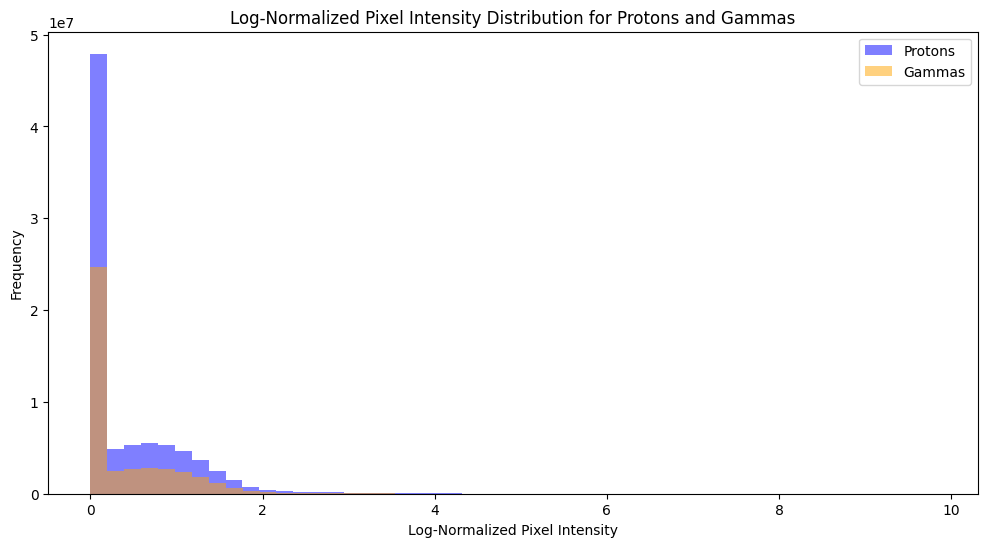

In [8]:
# clip negative values
proton_images_hillas = np.clip(proton_images_hillas, 0, None)
gamma_images_hillas = np.clip(gamma_images_hillas, 0, None)

# log normalization
proton_images_log = np.log1p(proton_images_hillas)
gamma_images_log = np.log1p(gamma_images_hillas)

# Show pixel distribution after log normalization
plt.figure(figsize=(12, 6))
plt.hist(proton_images_log.ravel(), bins=50, alpha=0.5, label='Protons', color='blue')
plt.hist(gamma_images_log.ravel(), bins=50, alpha=0.5, label='Gammas', color='orange')
plt.xlabel('Log-Normalized Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Log-Normalized Pixel Intensity Distribution for Protons and Gammas')
plt.legend()
plt.show()

In [9]:
file_list = glob.glob(os.path.join(proton_path, "*.h5"))
with EventSource(file_list[0]) as source:
    for i, event in enumerate(source):
        for tel_id, tel_event in event.dl1.tel.items():
            geo = source.subarray.tel[tel_id].camera.geometry
        break

neighbors = geo.neighbors

Table /r1/event/telescope/tel_002 is missing column first_cell_id for field first_cell_id of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.
Table /r1/event/telescope/tel_002 is missing column module_hires_local_clock_counter for field module_hires_local_clock_counter of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.
Table /r1/event/telescope/tel_002 is missing column pedestal_intensity for field pedestal_intensity of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.
Table /r1/event/telescope/tel_002 is missing column calibration_monitoring_id for field calibration_monitoring_id of container <class 'ctapipe.containers.R1CameraContainer'>. It will be skipped.


In [10]:

def clean_image_improvement(peak, mask, adj_list, max_diff=5):
    new_mask = mask.copy().astype(np.uint8)
    queue = deque(np.where(new_mask == 1)[0])

    while queue:
        i = queue.popleft()
        for n in adj_list[i]:
            if new_mask[n] == 0 and abs(peak[i] - peak[n]) <= max_diff:
                new_mask[n] = 1
                queue.append(n)

    return new_mask

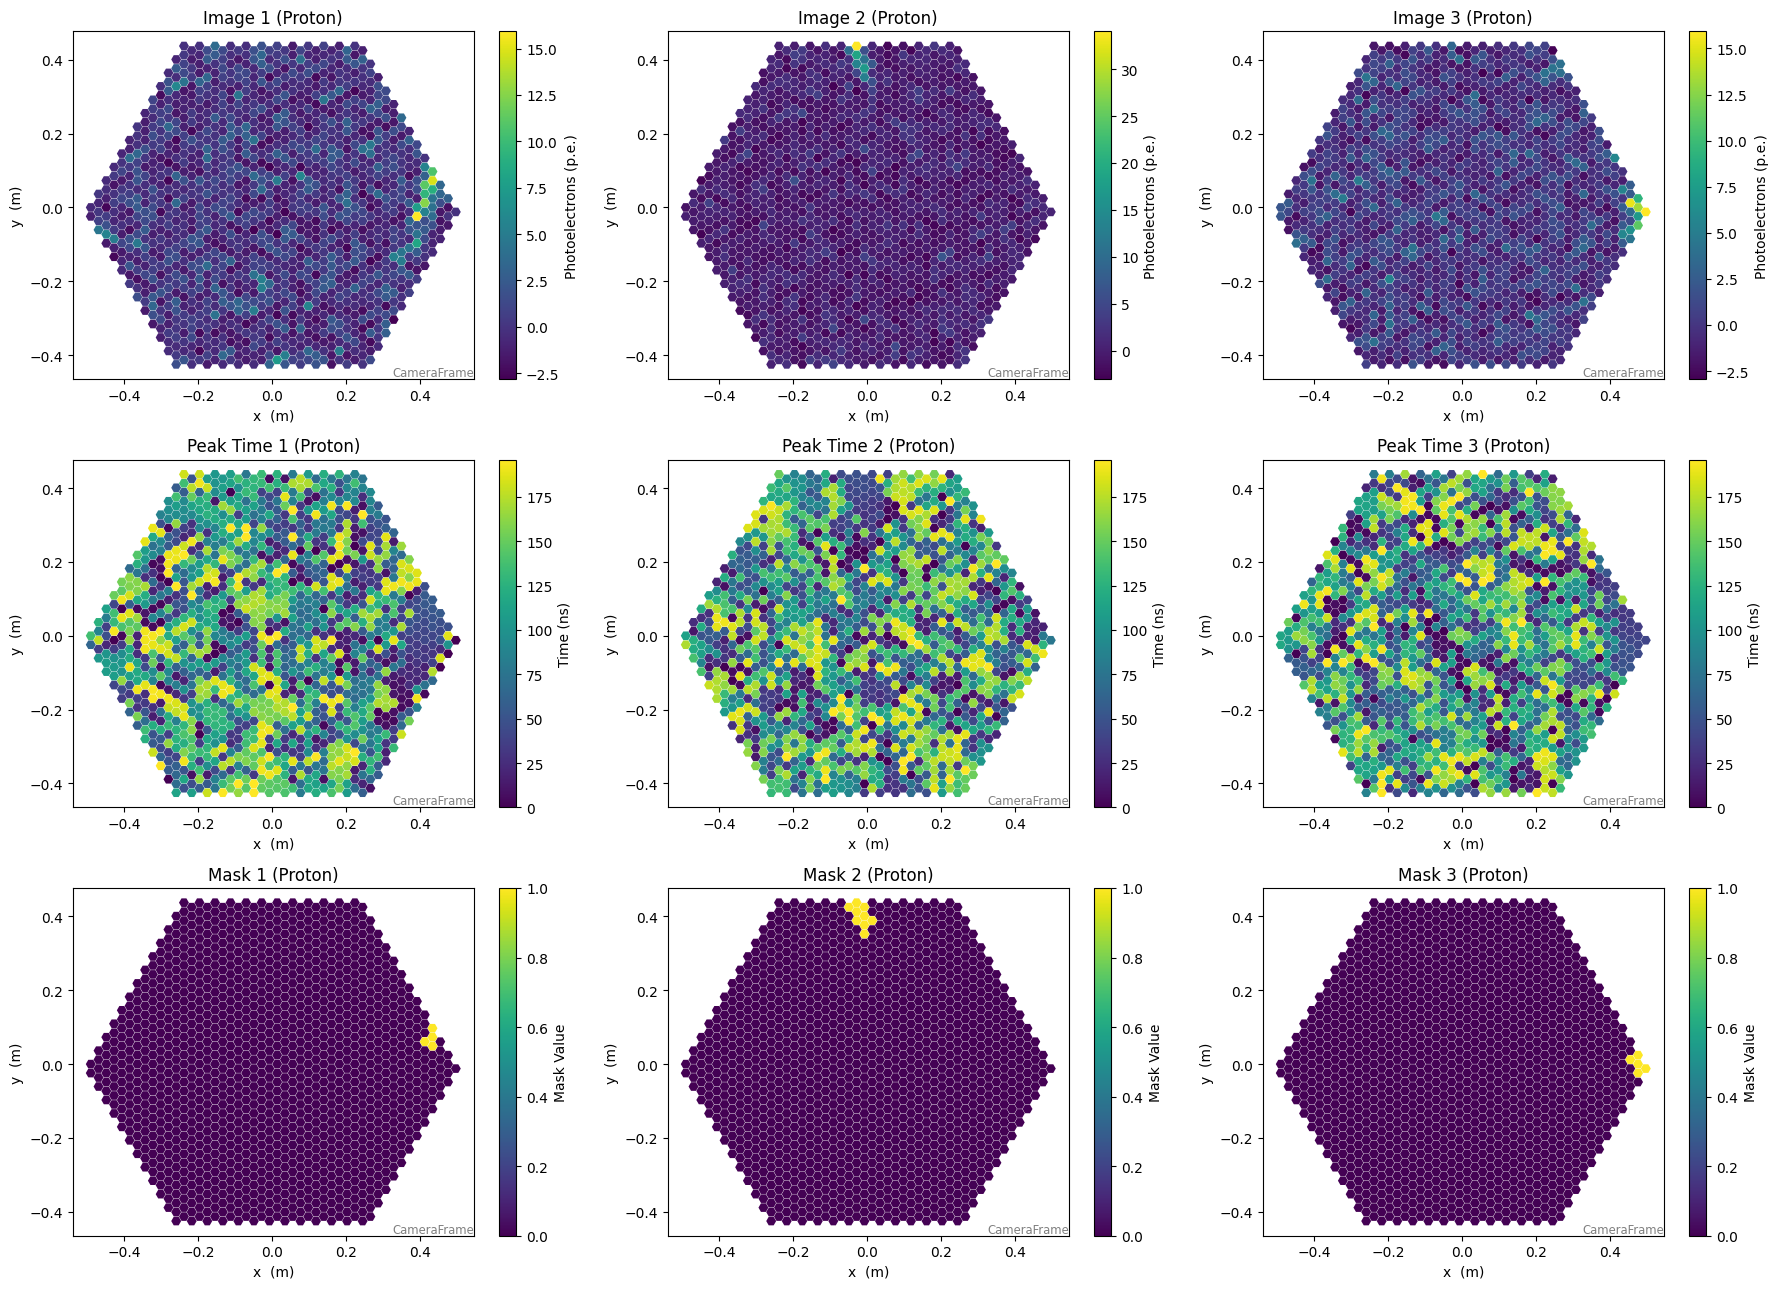

In [11]:
# show 3 exemple images after improvement

x = 600
y = 761
z = 200

fig, axes = plt.subplots(3, 3, figsize=(18, 13))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title=f"Image 1 (Proton)", image=proton_images_leakage[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp1 = CameraDisplay(geo, ax=axes[0, 1], title=f"Image 2 (Proton)", image=proton_images_leakage[y], cmap='viridis')
disp1.add_colorbar(label="Photoelectrons (p.e.)")
disp2 = CameraDisplay(geo, ax=axes[0, 2], title=f"Image 3 (Proton)", image=proton_images_leakage[z], cmap='viridis')
disp2.add_colorbar(label="Photoelectrons (p.e.)")

disp3 = CameraDisplay(geo, ax=axes[1, 0], title=f"Peak Time 1 (Proton)", image=protons_peak[x], cmap='viridis')
disp3.add_colorbar(label="Time (ns)")
disp4 = CameraDisplay(geo, ax=axes[1, 1], title=f"Peak Time 2 (Proton)", image=protons_peak[y], cmap='viridis')
disp4.add_colorbar(label="Time (ns)")
disp5 = CameraDisplay(geo, ax=axes[1, 2], title=f"Peak Time 3 (Proton)", image=protons_peak[z], cmap='viridis')
disp5.add_colorbar(label="Time (ns)")

disp6 = CameraDisplay(geo, ax=axes[2, 0], title=f"Mask 1 (Proton)", image=protons_mask[x], cmap='viridis')
disp6.add_colorbar(label="Mask Value")
disp7 = CameraDisplay(geo, ax=axes[2, 1], title=f"Mask 2 (Proton)", image=protons_mask[y], cmap='viridis')
disp7.add_colorbar(label="Mask Value")
disp8 = CameraDisplay(geo, ax=axes[2, 2], title=f"Mask 3 (Proton)", image=protons_mask[z], cmap='viridis')
disp8.add_colorbar(label="Mask Value")

plt.tight_layout()
plt.show()

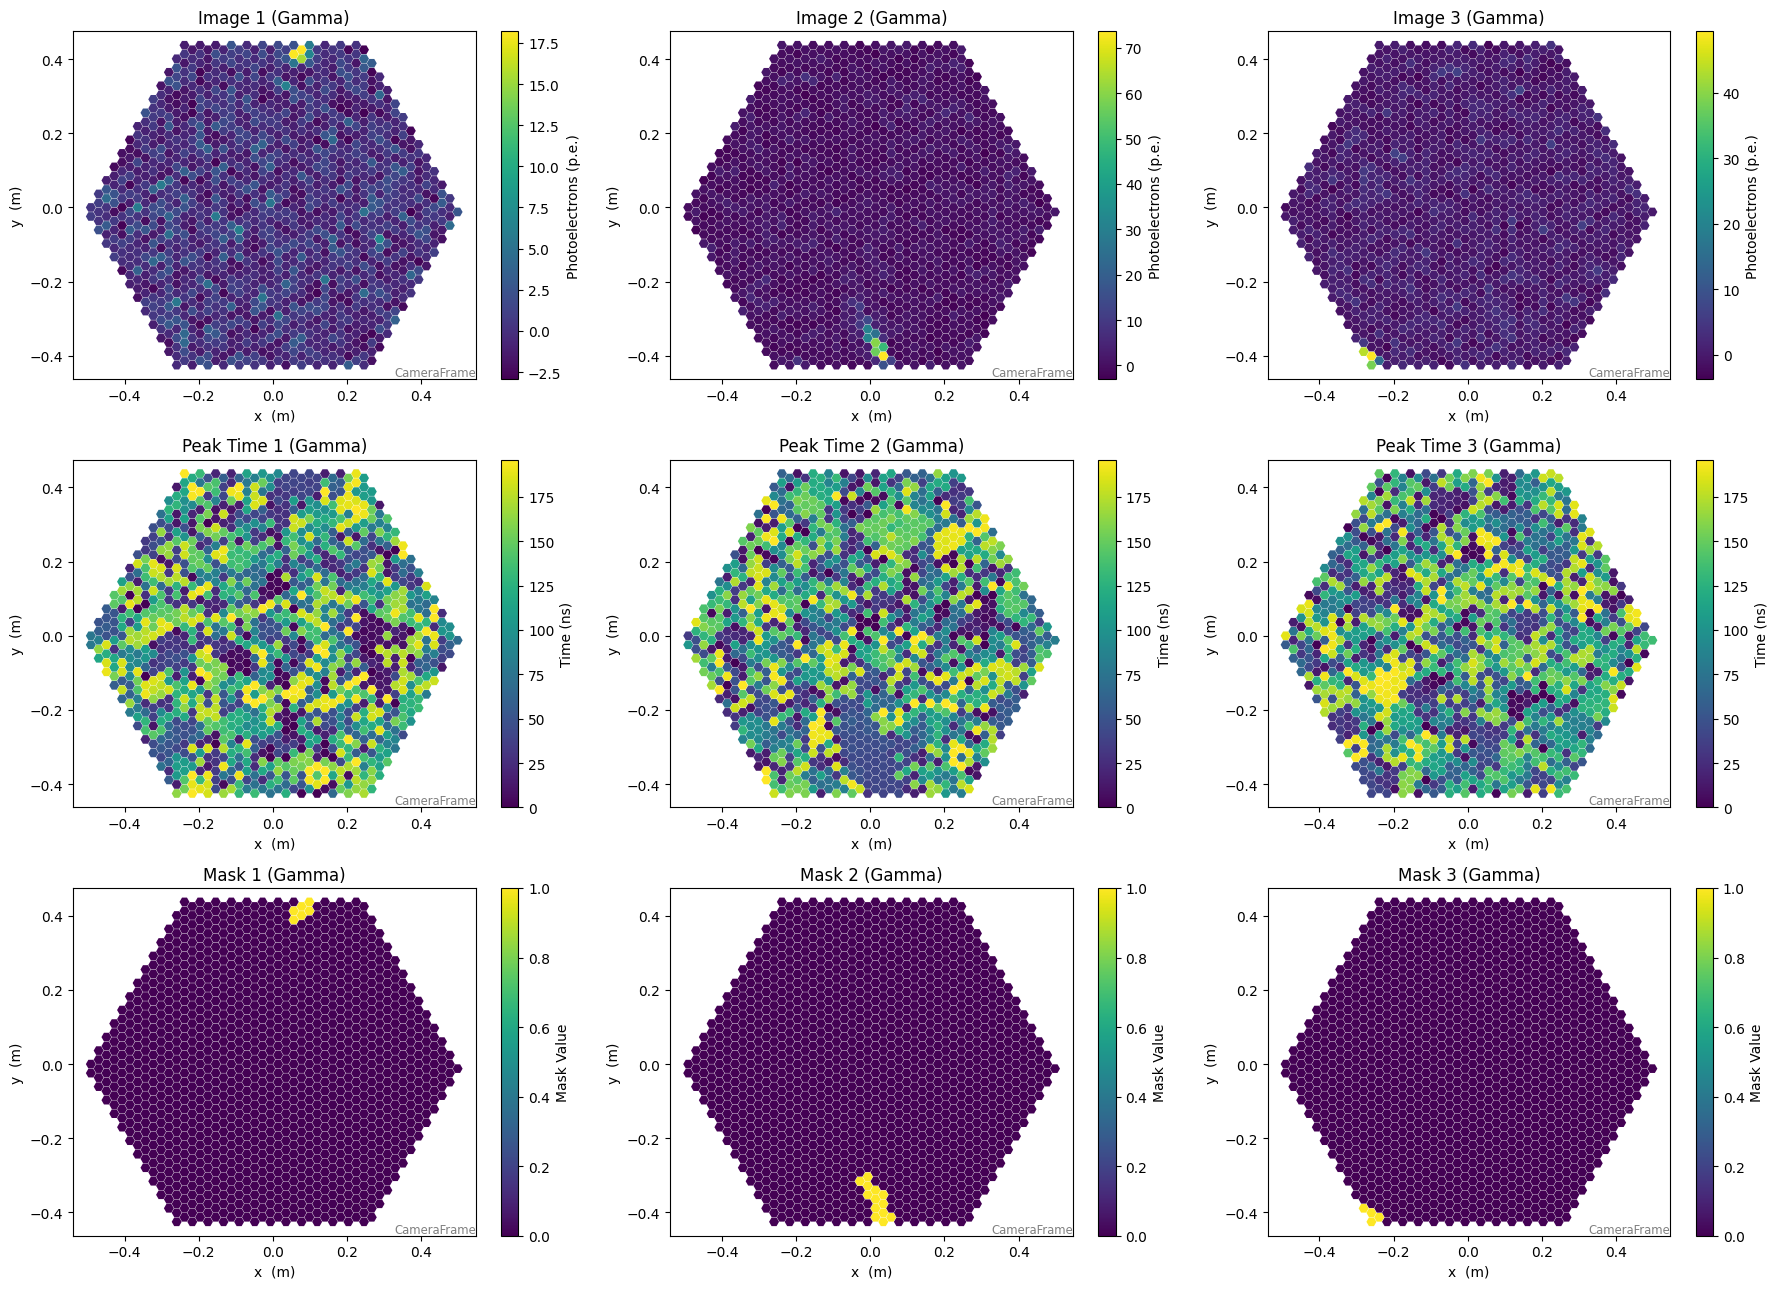

In [12]:
# show 3 exemple images after improvement

x = 599
y = 25
z = 122

fig, axes = plt.subplots(3, 3, figsize=(18, 13))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title=f"Image 1 (Gamma)", image=gamma_images_leakage[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp1 = CameraDisplay(geo, ax=axes[0, 1], title=f"Image 2 (Gamma)", image=gamma_images_leakage[y], cmap='viridis')
disp1.add_colorbar(label="Photoelectrons (p.e.)")
disp2 = CameraDisplay(geo, ax=axes[0, 2], title=f"Image 3 (Gamma)", image=gamma_images_leakage[z], cmap='viridis')
disp2.add_colorbar(label="Photoelectrons (p.e.)")

disp3 = CameraDisplay(geo, ax=axes[1, 0], title=f"Peak Time 1 (Gamma)", image=gammas_peak[x], cmap='viridis')
disp3.add_colorbar(label="Time (ns)")
disp4 = CameraDisplay(geo, ax=axes[1, 1], title=f"Peak Time 2 (Gamma)", image=gammas_peak[y], cmap='viridis')
disp4.add_colorbar(label="Time (ns)")
disp5 = CameraDisplay(geo, ax=axes[1, 2], title=f"Peak Time 3 (Gamma)", image=gammas_peak[z], cmap='viridis')
disp5.add_colorbar(label="Time (ns)")

disp6 = CameraDisplay(geo, ax=axes[2, 0], title=f"Mask 1 (Gamma)", image=gammas_mask[x], cmap='viridis')
disp6.add_colorbar(label="Mask Value")
disp7 = CameraDisplay(geo, ax=axes[2, 1], title=f"Mask 2 (Gamma)", image=gammas_mask[y], cmap='viridis')
disp7.add_colorbar(label="Mask Value")
disp8 = CameraDisplay(geo, ax=axes[2, 2], title=f"Mask 3 (Gamma)", image=gammas_mask[z], cmap='viridis')
disp8.add_colorbar(label="Mask Value")

plt.tight_layout()
plt.show()

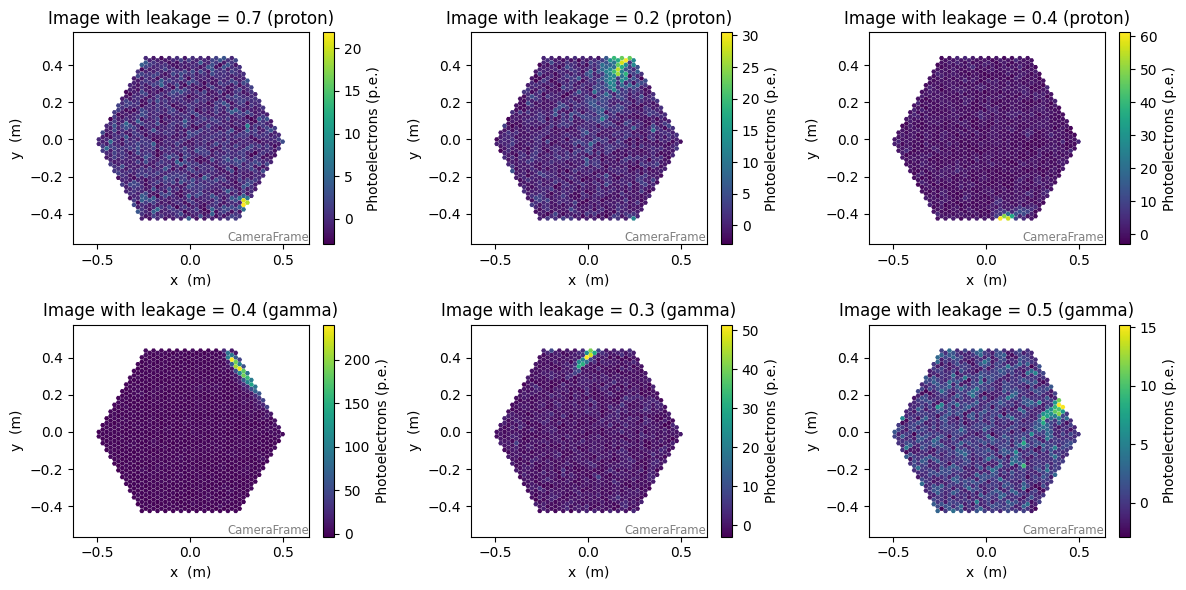

In [13]:
# show 3 exemple images after improvement

x = 60
y = 30
z = 10

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title=f"Image with leakage = {proton_leakage[x]:.1f} (proton)", image=proton_images_leakage[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp1 = CameraDisplay(geo, ax=axes[0, 1], title=f"Image with leakage = {proton_leakage[y]:.1f} (proton)", image=proton_images_leakage[y], cmap='viridis')
disp1.add_colorbar(label="Photoelectrons (p.e.)")
disp2 = CameraDisplay(geo, ax=axes[0, 2], title=f"Image with leakage = {proton_leakage[z]:.1f} (proton)", image=proton_images_leakage[z], cmap='viridis')
disp2.add_colorbar(label="Photoelectrons (p.e.)")

disp3 = CameraDisplay(geo, ax=axes[1, 0], title=f"Image with leakage = {gamma_leakage[x]:.1f} (gamma)", image=gamma_images_leakage[x], cmap='viridis')
disp3.add_colorbar(label="Photoelectrons (p.e.)")
disp4 = CameraDisplay(geo, ax=axes[1, 1], title=f"Image with leakage = {gamma_leakage[y]:.1f} (gamma)", image=gamma_images_leakage[y], cmap='viridis')
disp4.add_colorbar(label="Photoelectrons (p.e.)")
disp5 = CameraDisplay(geo, ax=axes[1, 2], title=f"Image with leakage = {gamma_leakage[z]:.1f} (gamma)", image=gamma_images_leakage[z], cmap='viridis')
disp5.add_colorbar(label="Photoelectrons (p.e.)")

plt.tight_layout()
plt.show()

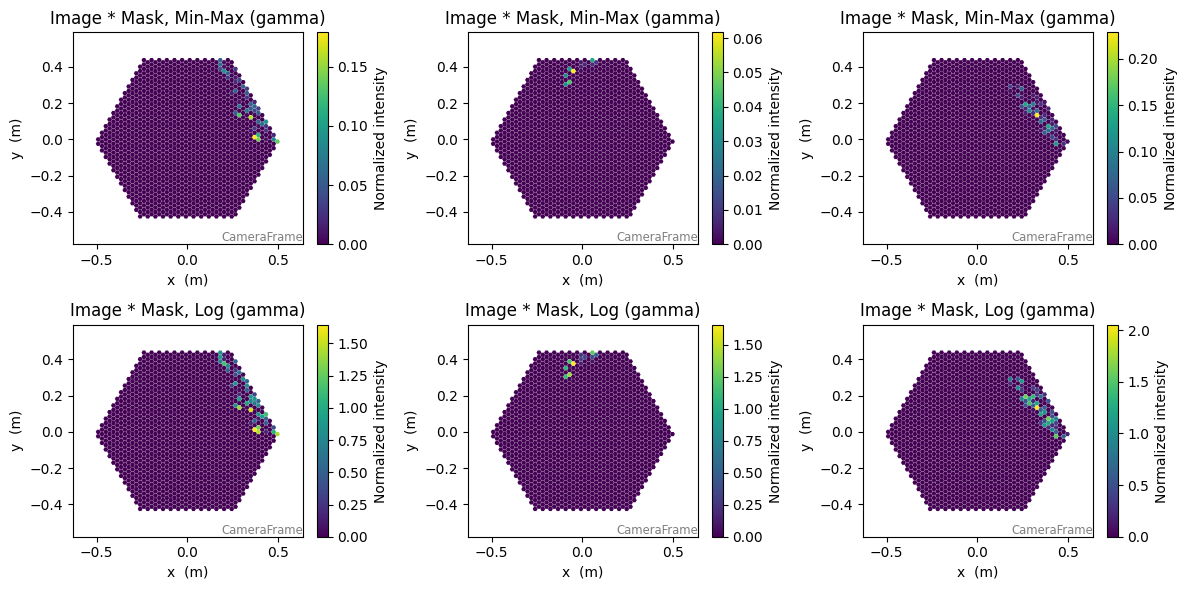

In [14]:
# show 3 exemple images after improvement

x = 60
y = 30
z = 470

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

clean_mask_x = clean_image_improvement(gammas_peak[x], gammas_mask[x], neighbors, max_diff=5)
clean_mask_y = clean_image_improvement(gammas_peak[y], gammas_mask[y], neighbors, max_diff=5)
clean_mask_z = clean_image_improvement(gammas_peak[z], gammas_mask[z], neighbors, max_diff=5)

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image * Mask, Min-Max (gamma)", image=gamma_images_hillas[x] * clean_mask_x / np.max(gamma_images_hillas[x]), cmap='viridis')
disp0.add_colorbar(label="Normalized intensity")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image * Mask, Min-Max (gamma)", image=gamma_images_hillas[y] * clean_mask_y / np.max(gamma_images_hillas[y]),cmap='viridis')
disp01.add_colorbar(label="Normalized intensity")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image * Mask, Min-Max (gamma)", image=gamma_images_hillas[z] * clean_mask_z / np.max(gamma_images_hillas[z]), cmap='viridis')
disp02.add_colorbar(label="Normalized intensity")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Image * Mask, Log (gamma)", image=gamma_images_log[x] * clean_mask_x, cmap='viridis')
disp1.add_colorbar(label="Normalized intensity")

disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Image * Mask, Log (gamma)", image=gamma_images_log[y] * clean_mask_y, cmap='viridis')
disp10.add_colorbar(label="Normalized intensity")

disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Image * Mask, Log (gamma)", image=gamma_images_log[z] * clean_mask_z, cmap='viridis')
disp11.add_colorbar(label="Normalized intensity")

plt.tight_layout()
plt.show()

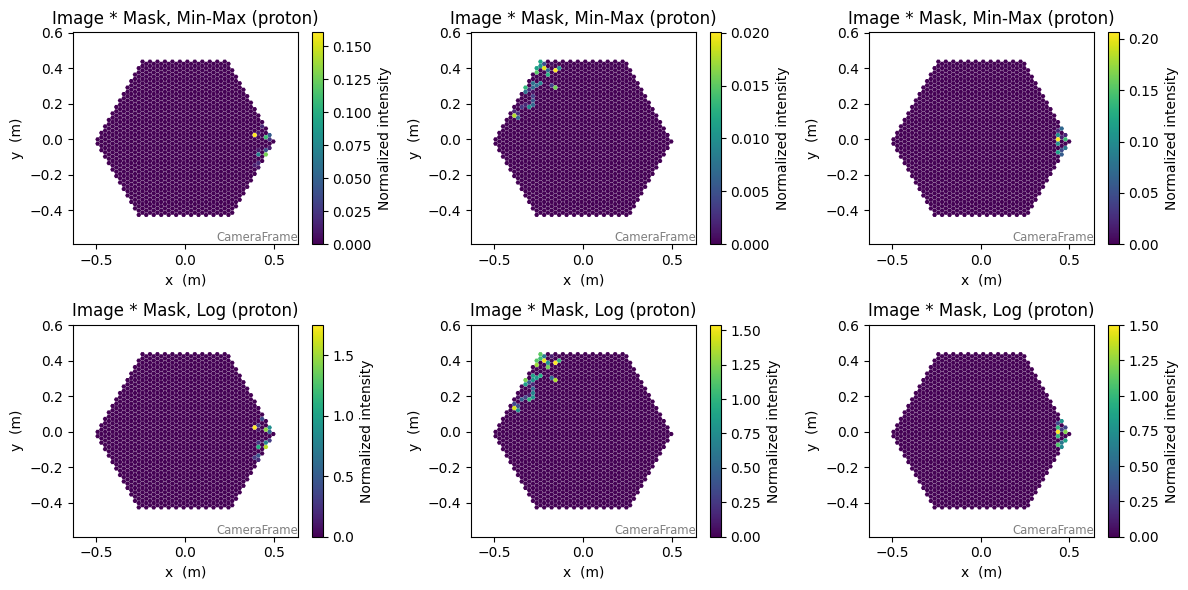

In [15]:
# show 3 exemple images after improvement (proton)

x = 160
y = 300
z = 200

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
clean_mask_x = clean_image_improvement(protons_peak[x], protons_mask[x], neighbors, max_diff=5)
clean_mask_y = clean_image_improvement(protons_peak[y], protons_mask[y], neighbors, max_diff=5)
clean_mask_z = clean_image_improvement(protons_peak[z], protons_mask[z], neighbors, max_diff=5)

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image * Mask, Min-Max (proton)", image=proton_images_hillas[x] * clean_mask_x / np.max(proton_images_hillas[x]), cmap='viridis')
disp0.add_colorbar(label="Normalized intensity")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image * Mask, Min-Max (proton)", image=proton_images_hillas[y] * clean_mask_y / np.max(proton_images_hillas[y]), cmap='viridis')
disp01.add_colorbar(label="Normalized intensity")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image * Mask, Min-Max (proton)", image=proton_images_hillas[z] * clean_mask_z / np.max(proton_images_hillas[z]), cmap='viridis')
disp02.add_colorbar(label="Normalized intensity")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Image * Mask, Log (proton)", image=proton_images_log[x] * clean_mask_x, cmap='viridis')
disp1.add_colorbar(label="Normalized intensity")
disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Image * Mask, Log (proton)", image=proton_images_log[y] * clean_mask_y, cmap='viridis')
disp10.add_colorbar(label="Normalized intensity")
disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Image * Mask, Log (proton)", image=proton_images_log[z] * clean_mask_z, cmap='viridis')
disp11.add_colorbar(label="Normalized intensity")
plt.tight_layout()
plt.show()

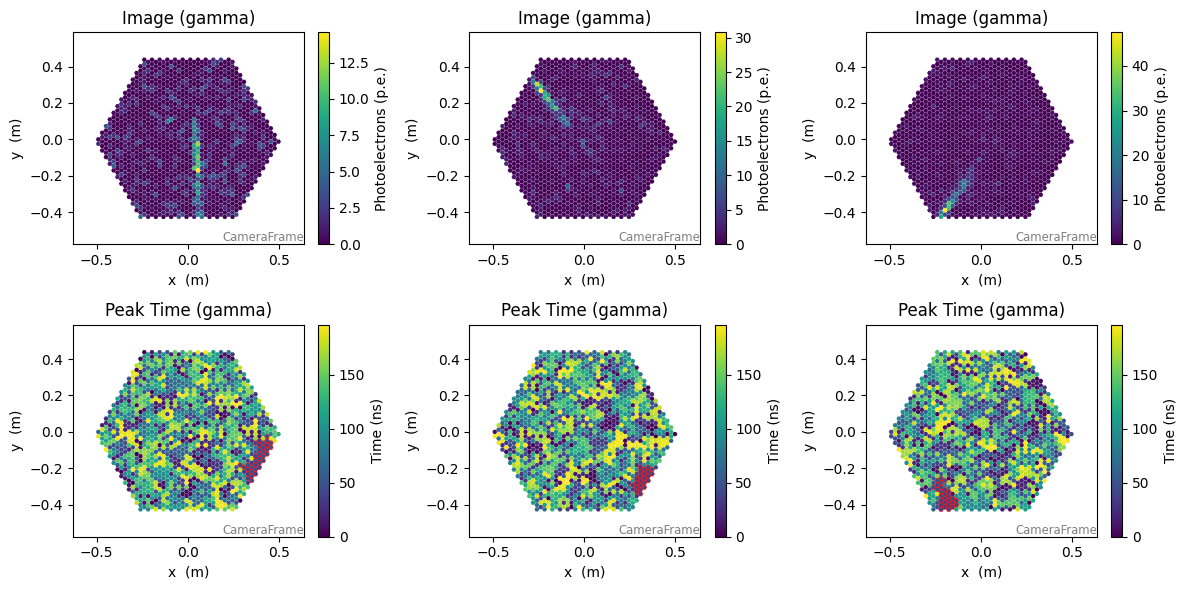

In [16]:
# Shuffle images for visualization
random.seed(42)
#random.shuffle(proton_images_hillas)
#random.shuffle(proton_images_no_hillas)

x = 22
y = 116
z = 100

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image (gamma)", image=gamma_images_hillas[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image (gamma)", image=gamma_images_hillas[y], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image (gamma)", image=gamma_images_hillas[z], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Peak Time (gamma)", image=gammas_peak[x], cmap='viridis')
disp1.add_colorbar(label="Time (ns)")
disp1.highlight_pixels(clean_image_improvement(gammas_peak[x], gammas_mask[x], neighbors, max_diff=5).astype(bool), color='red', linewidth=.5)

disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Peak Time (gamma)", image=gammas_peak[y], cmap='viridis')
disp10.add_colorbar(label="Time (ns)")
disp10.highlight_pixels(clean_image_improvement(gammas_peak[y], gammas_mask[y], neighbors, max_diff=5).astype(bool), color='red', linewidth=.5)

disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Peak Time (gamma)", image=gammas_peak[z], cmap='viridis')
disp11.add_colorbar(label="Time (ns)")
disp11.highlight_pixels(clean_image_improvement(gammas_peak[z], gammas_mask[z], neighbors, max_diff=5).astype(bool), color='red', linewidth=.5)

plt.tight_layout()
plt.show()

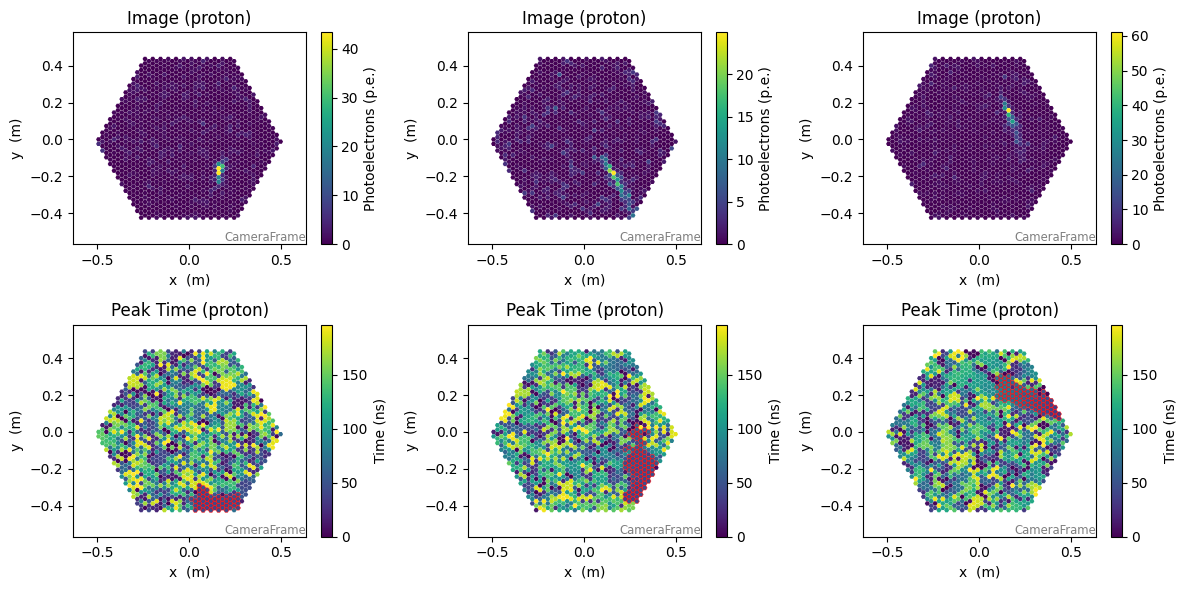

In [17]:
# Shuffle images for visualization
random.seed(42)
#random.shuffle(proton_images_hillas)
#random.shuffle(proton_images_no_hillas)

x = 10
y = 1160
z = 28

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image (proton)", image=proton_images_hillas[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image (proton)", image=proton_images_hillas[y], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image (proton)", image=proton_images_hillas[z], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Peak Time (proton)", image=protons_peak[x], cmap='viridis')
disp1.add_colorbar(label="Time (ns)")
disp1.highlight_pixels(clean_image_improvement(protons_peak[x], protons_mask[x], neighbors, max_diff=5).astype(bool), color='red', linewidth=.5)

disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Peak Time (proton)", image=protons_peak[y], cmap='viridis')
disp10.add_colorbar(label="Time (ns)")
disp10.highlight_pixels(clean_image_improvement(protons_peak[y], protons_mask[y], neighbors, max_diff=5).astype(bool), color='red', linewidth=.5)

disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Peak Time (proton)", image=protons_peak[z], cmap='viridis')
disp11.add_colorbar(label="Time (ns)")
disp11.highlight_pixels(clean_image_improvement(protons_peak[z], protons_mask[z], neighbors, max_diff=5).astype(bool), color='red', linewidth=.5)

plt.tight_layout()
plt.show()

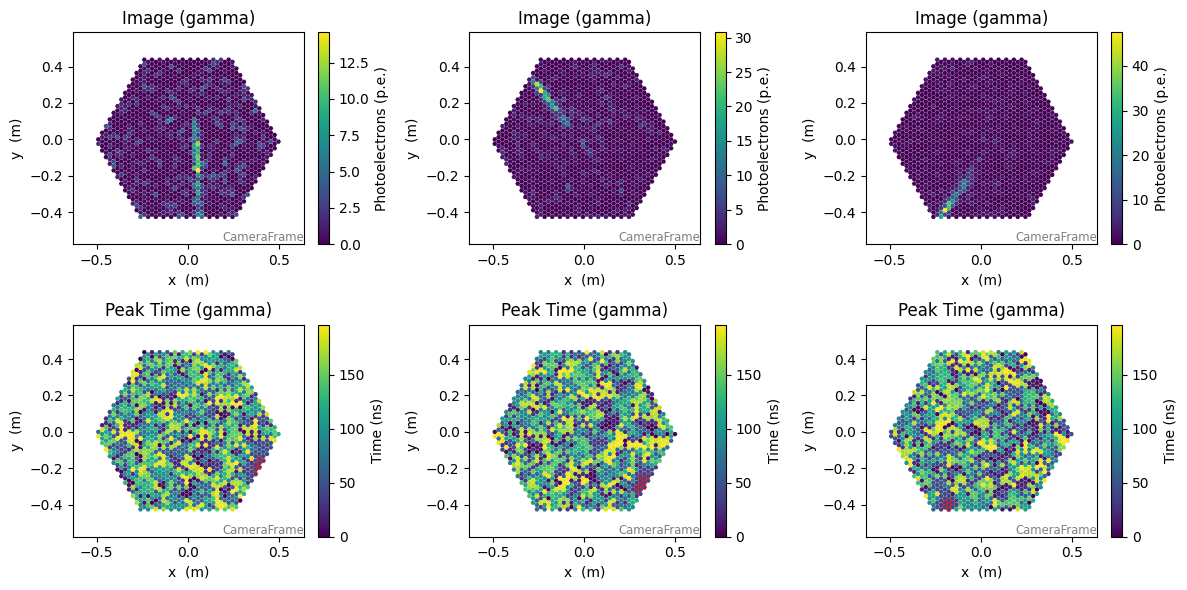

In [18]:
# Shuffle images for visualization
random.seed(42)
#random.shuffle(proton_images_hillas)
#random.shuffle(proton_images_no_hillas)

x = 22
y = 116
z = 100

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image (gamma)", image=gamma_images_hillas[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image (gamma)", image=gamma_images_hillas[y], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image (gamma)", image=gamma_images_hillas[z], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Peak Time (gamma)", image=gammas_peak[x], cmap='viridis')
disp1.add_colorbar(label="Time (ns)")
disp1.highlight_pixels(gammas_mask[x], color='red', linewidth=.5)

disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Peak Time (gamma)", image=gammas_peak[y], cmap='viridis')
disp10.add_colorbar(label="Time (ns)")
disp10.highlight_pixels(gammas_mask[y], color='red', linewidth=.5)

disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Peak Time (gamma)", image=gammas_peak[z], cmap='viridis')
disp11.add_colorbar(label="Time (ns)")
disp11.highlight_pixels(gammas_mask[z], color='red', linewidth=.5)

plt.tight_layout()
plt.show()

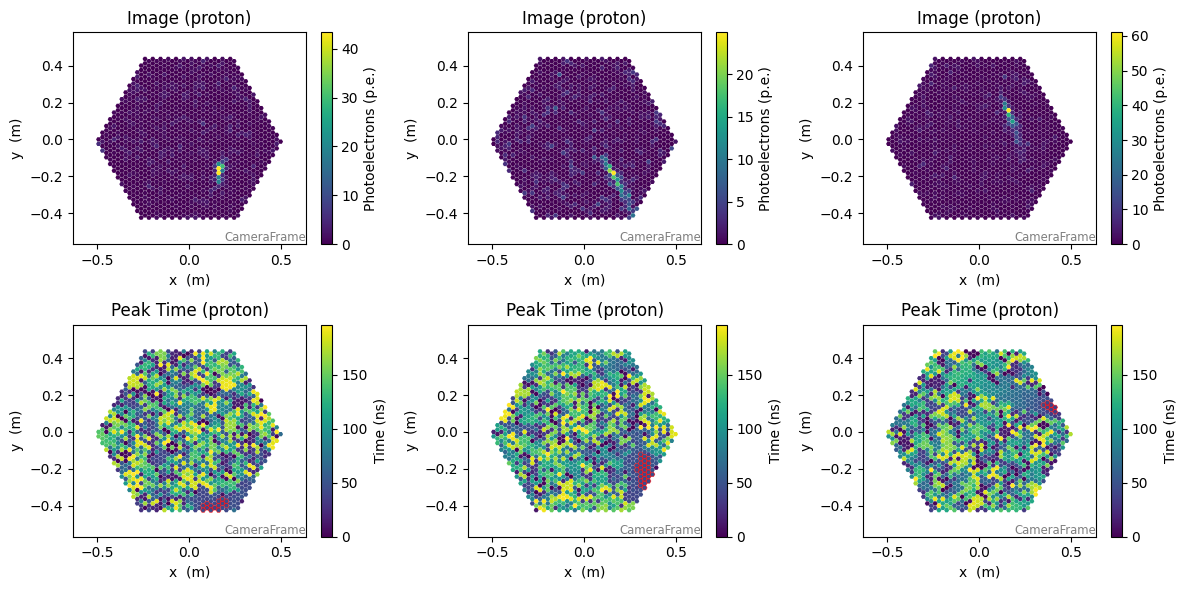

In [19]:
# Shuffle images for visualization
random.seed(42)
#random.shuffle(proton_images_hillas)
#random.shuffle(proton_images_no_hillas)

x = 10
y = 1160
z = 28

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image (proton)", image=proton_images_hillas[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image (proton)", image=proton_images_hillas[y], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image (proton)", image=proton_images_hillas[z], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Peak Time (proton)", image=protons_peak[x], cmap='viridis')
disp1.add_colorbar(label="Time (ns)")
disp1.highlight_pixels(protons_mask[x], color='red', linewidth=.5)

disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Peak Time (proton)", image=protons_peak[y], cmap='viridis')
disp10.add_colorbar(label="Time (ns)")
disp10.highlight_pixels(protons_mask[y], color='red', linewidth=.5)

disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Peak Time (proton)", image=protons_peak[z], cmap='viridis')
disp11.add_colorbar(label="Time (ns)")
disp11.highlight_pixels(protons_mask[z], color='red', linewidth=.5)

plt.tight_layout()
plt.show()

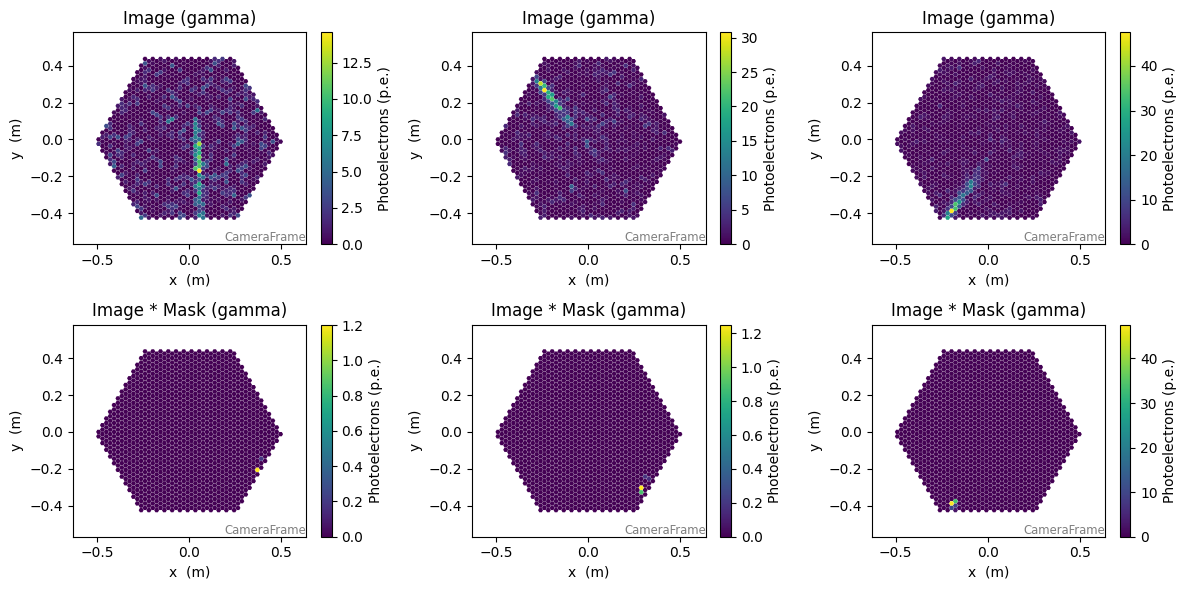

In [20]:
# Shuffle images for visualization
random.seed(42)
#random.shuffle(proton_images_hillas)
#random.shuffle(proton_images_no_hillas)

x = 22
y = 116
z = 100

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image (gamma)", image=gamma_images_hillas[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image (gamma)", image=gamma_images_hillas[y], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image (gamma)", image=gamma_images_hillas[z], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Image * Mask (gamma)", image=gamma_images_hillas[x]*gammas_mask[x], cmap='viridis')
disp1.add_colorbar(label="Photoelectrons (p.e.)")
disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Image * Mask (gamma)", image=gamma_images_hillas[y]*gammas_mask[y], cmap='viridis')
disp10.add_colorbar(label="Photoelectrons (p.e.)")
disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Image * Mask (gamma)", image=gamma_images_hillas[z]*gammas_mask[z], cmap='viridis')
disp11.add_colorbar(label="Photoelectrons (p.e.)")
plt.tight_layout()
plt.show()

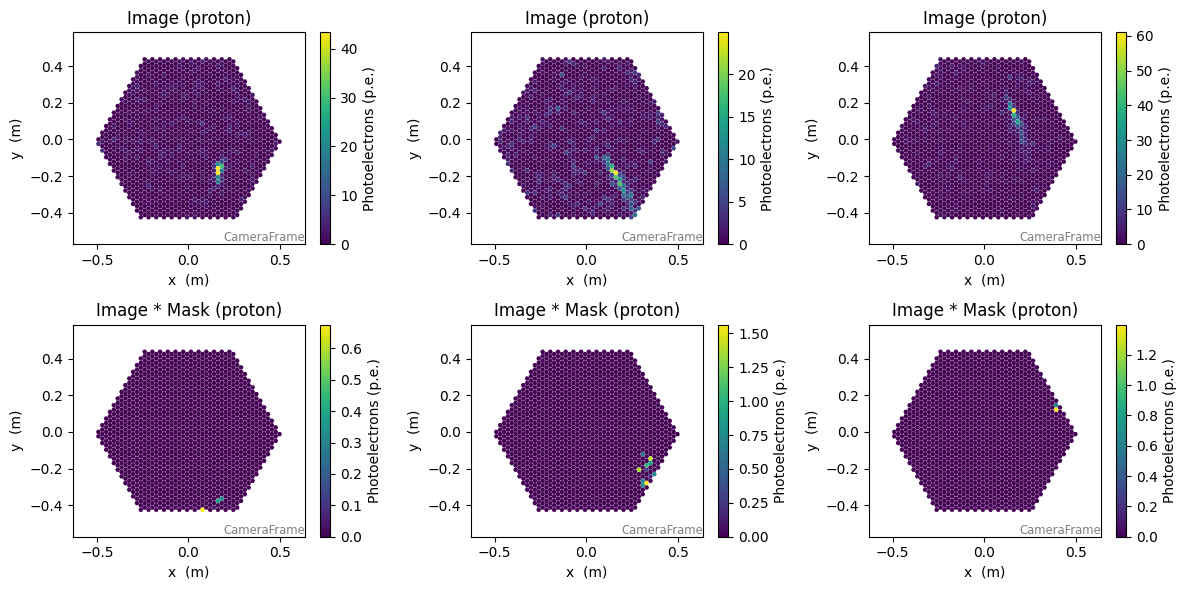

In [21]:
# Shuffle images for visualization
random.seed(42)
#random.shuffle(proton_images_hillas)
#random.shuffle(proton_images_no_hillas)

x = 10
y = 1160
z = 28

fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="Image (proton)", image=proton_images_hillas[x], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="Image (proton)", image=proton_images_hillas[y], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="Image (proton)", image=proton_images_hillas[z], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Image * Mask (proton)", image=proton_images_hillas[x]*protons_mask[x], cmap='viridis')
disp1.add_colorbar(label="Photoelectrons (p.e.)")
disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Image * Mask (proton)", image=proton_images_hillas[y]*protons_mask[y], cmap='viridis')
disp10.add_colorbar(label="Photoelectrons (p.e.)")
disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Image * Mask (proton)", image=proton_images_hillas[z]*protons_mask[z], cmap='viridis')
disp11.add_colorbar(label="Photoelectrons (p.e.)")
plt.tight_layout()
plt.show()

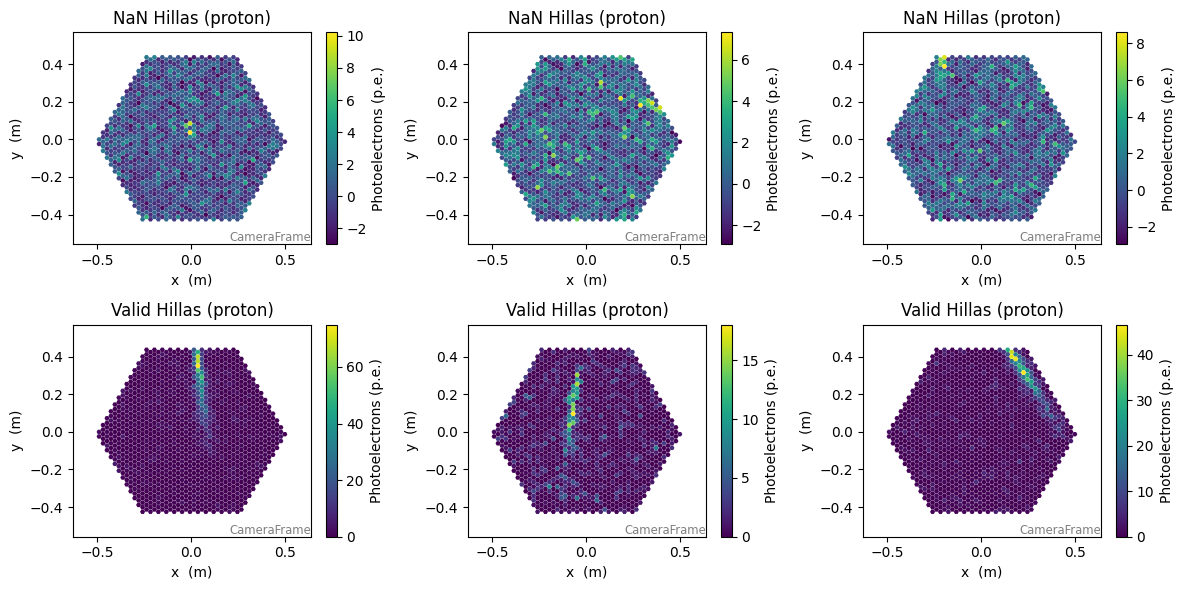

In [22]:
# Shuffle images for visualization
random.seed(42)
#random.shuffle(proton_images_hillas)
#random.shuffle(proton_images_no_hillas)


fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="NaN Hillas (proton)", image=proton_images_no_hillas[18], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="NaN Hillas (proton)", image=proton_images_no_hillas[13], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="NaN Hillas (proton)", image=proton_images_no_hillas[16], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Valid Hillas (proton)", image=proton_images_hillas[25], cmap='viridis')
disp1.add_colorbar(label="Photoelectrons (p.e.)")
disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Valid Hillas (proton)", image=proton_images_hillas[16], cmap='viridis')
disp10.add_colorbar(label="Photoelectrons (p.e.)")
disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Valid Hillas (proton)", image=proton_images_hillas[15], cmap='viridis')
disp11.add_colorbar(label="Photoelectrons (p.e.)")
plt.tight_layout()
plt.show()

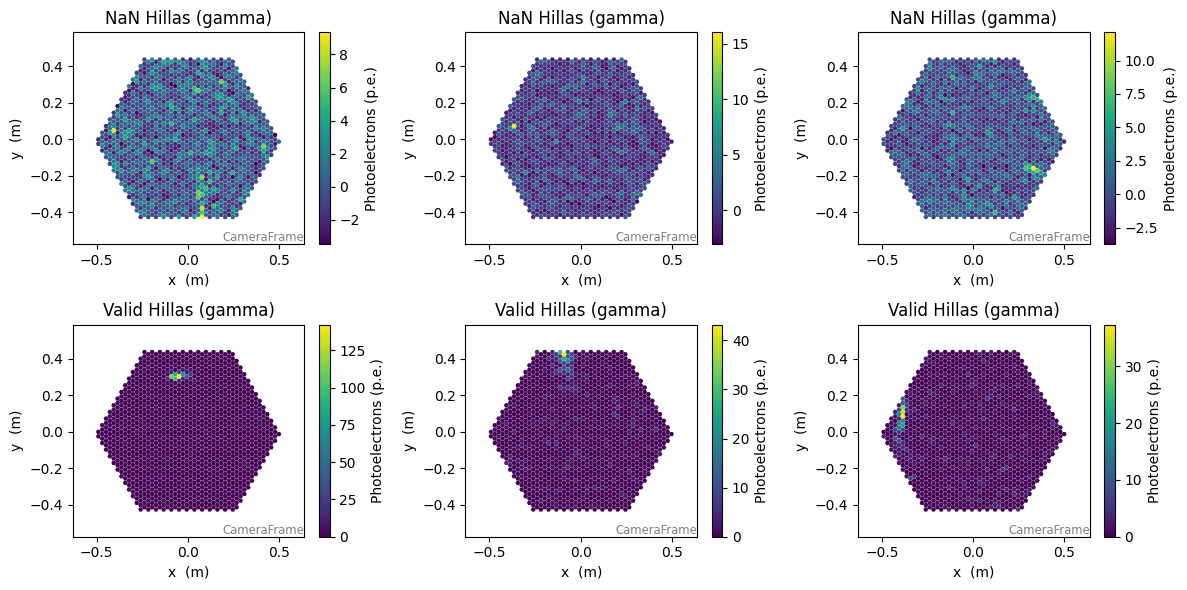

In [ ]:
# Shuffle images for visualization
random.seed(42)
random.shuffle(gamma_images_no_hillas)
random.shuffle(gamma_images_hillas)


fig, axes = plt.subplots(2, 3, figsize=(12, 6))

disp0 = CameraDisplay(geo, ax=axes[0, 0], title="NaN Hillas (gamma)", image=gamma_images_no_hillas[0], cmap='viridis')
disp0.add_colorbar(label="Photoelectrons (p.e.)")
disp01 = CameraDisplay(geo, ax=axes[0, 1], title="NaN Hillas (gamma)", image=gamma_images_no_hillas[504], cmap='viridis')
disp01.add_colorbar(label="Photoelectrons (p.e.)")
disp02 = CameraDisplay(geo, ax=axes[0, 2], title="NaN Hillas (gamma)", image=gamma_images_no_hillas[2018], cmap='viridis')
disp02.add_colorbar(label="Photoelectrons (p.e.)")

disp1 = CameraDisplay(geo, ax=axes[1, 0], title="Valid Hillas (gamma)", image=gamma_images_hillas[9], cmap='viridis')
disp1.add_colorbar(label="Photoelectrons (p.e.)")
disp10 = CameraDisplay(geo, ax=axes[1, 1], title="Valid Hillas (gamma)", image=gamma_images_hillas[23], cmap='viridis')
disp10.add_colorbar(label="Photoelectrons (p.e.)")
disp11 = CameraDisplay(geo, ax=axes[1, 2], title="Valid Hillas (gamma)", image=gamma_images_hillas[4], cmap='viridis')
disp11.add_colorbar(label="Photoelectrons (p.e.)")
plt.tight_layout()
plt.show()